# CS4305TU - Assignment 2 - Regression

In this assignment, you will apply your newly obtained regression techniques with real-life data. **You should work in groups for this assignment.**

## Data source

What you will be playing with is aircraft trajectory data derived from [ADS-B](https://www.skybrary.aero/index.php/Automatic_Dependent_Surveillance_Broadcast_(ADS-B)). It is collected using the antenna from the top of the aerospace building:

<img src="https://pbs.twimg.com/media/EoBz7vVXEAAze48?format=jpg&name=medium" width="400"/>

Ensentially, ADS-B data is what you see on website like FlightRadar24:

<img src="https://media.giphy.com/media/cPutGcE0a9jdS/giphy.gif" width="400"/>

## Background

In the dataset, all flight trajectories include only the descent part of the flight. The dataset is split into two directories. One directory contains flights that are following the [Continous Descent Approach (CDA)](https://www.skybrary.aero/index.php/Continuous_Descent). The other directory contains flights that do not follow CDA. 

CDA is an operation, where the aircraft does not have any level flight segment during the descent. Follow the link above to know more.

<img src="https://1.bp.blogspot.com/-UFmjVcjmqCM/UIai54Y_wYI/AAAAAAAAAUM/tW1HTFP1IGI/s1600/image02_05_large.gif" width="400">


## Data attributes

The structures of all CSV files are the same. Here are descriptions of all columns:

- **time**: flight time in seconds, the first row starts at time 0.
- **icao**: aircraft transponder address, string format, unique for each aircraft.
- **type**: aircraft type code, string format.
- **callsign**: string format, often related to the flight number, unique for each flight.
- **latitude**: latitude coordinate in degrees.
- **longitude**: latitude coordinate  in degrees.
- **speed**: aircraft speed respective to ground, unit is in knots (1 knot = 0.51444 m/s).
- **track_angle**: direction of aircraft in relation to the true north, in degrees.
- **vertical_rate**: aircraft climb or descent speed in feet/minute (1 ft/min = 000508 m/s), negative value indicates aircraft is descending.

The most important features we are using are **time**, **altitude**, **speed**, and **vertical_rate**. 

## Instructions

The code in this notebook serves as the base for your assignment. The tasks are defined in each section.

You should implement the solutions using code cells and write your analysis using markdown cells.

Once you have complete everything, before submission, remember to restart the kernel and run all cells again. Make sure there are no errors. Then you should:

 - Save the notebook (**replace XX in the filename with your group number**)
 - Export a HTML version of the notebook. Hint: follow Mene -> File -> Download as -> HTML
 - Submit both the notebook (.ipynb) and the export (.html)


 ## References

- Quick tutorial for **Jupyter Notebook** : https://www.youtube.com/watch?v=2eCHD6f_phE

- Quick tutorial for **Jupyter Lab** (if you wish to use): https://www.youtube.com/watch?v=A5YyoCKxEOU
 

In [32]:
import glob
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

In [33]:
# loading all trajectory files

cda_files = sorted(glob.glob("data/cda/*.csv"))
noncda_files = sorted(glob.glob("data/noncda/*.csv"))

## Examples

Following two cells are some examples for data and plotting.

Remove these before submit your assignment.

In [34]:
df_example = pd.read_csv(cda_files[0])
df_example.head(10)

,time,icao,type,callsign,latitude,longitude,altitude,speed,track_angle,vertical_rate
0,0.0,40631F,A319,EZY58YF,52.79041,2.55135,24975,445,101,-192
1,20.0,40631F,A319,EZY58YF,52.78042,2.61632,24625,441,106,-1408
2,40.0,40631F,A319,EZY58YF,52.76827,2.68098,23925,436,107,-2304
3,60.0,40631F,A319,EZY58YF,52.75611,2.74282,23225,432,107,-1984
4,80.0,40631F,A319,EZY58YF,52.74248,2.81368,22550,425,107,-1728
5,100.0,40631F,A319,EZY58YF,52.73261,2.86673,22000,420,106,-2112
6,140.0,40631F,A319,EZY58YF,52.70906,2.99515,20550,411,106,-2112
7,160.0,40631F,A319,EZY58YF,52.69504,3.07138,19900,400,106,-1344
8,180.0,40631F,A319,EZY58YF,52.68875,3.10529,19550,397,106,-2304
9,200.0,40631F,A319,EZY58YF,52.67740,3.16626,18775,396,107,-1664


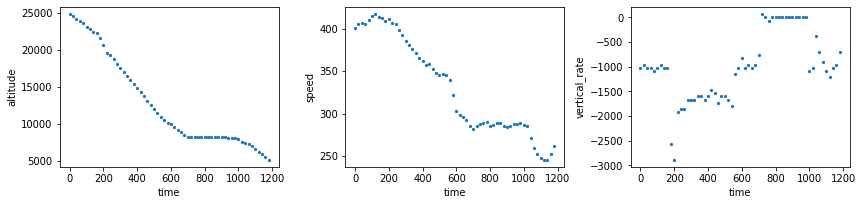

In [35]:
# visualization example

flight_sample = pd.read_csv(noncda_files[0])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(flight_sample.time, flight_sample.altitude, s=5)
ax[0].set_xlabel("time")
ax[0].set_ylabel("altitude")
ax[1].scatter(flight_sample.time, flight_sample.speed, s=5)
ax[1].set_xlabel("time")
ax[1].set_ylabel("speed")
ax[2].scatter(flight_sample.time, flight_sample.vertical_rate, s=5)
ax[2].set_xlabel("time")
ax[2].set_ylabel("vertical_rate")
plt.tight_layout()
plt.show()

# Task 1: Simple linear regression 

In this task you will learn how to apply simple linear regression model using a couple of flight trajectories. To complete the task, follow the steps below:

1. Use you group id as random seed, select one flight from CDA trajectories, and another one from Non-CDA trajectories

1. Inspect the relationships of (time, altitude), (time, speed), and (time, vertical_rate) for these two trajectories.

1. Apply linear regression to all three parameters for both trajectories, using time as input and altitude as output.

1. Evaluate the performance of the estimators using different error metrics.

In [36]:
# set group_id to your own group number

group_id = 16

In [37]:
np.random.seed(group_id)

cda_filename = np.random.choice(cda_files)
noncda_filename = np.random.choice(noncda_files)

df_cda = pd.read_csv(cda_filename)
df_noncda = pd.read_csv(noncda_filename)

type_cda = df_cda["type"].iloc[0]
type_noncda = df_noncda["type"].iloc[0]

In [38]:
# Task 1
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    r2_score,
)
def plot_data(ax,df,xcol,ycol):
    x = df[xcol].values
    y = df[ycol].values
    type = df.index.values
    
    ax.scatter(x, y, color="k",s=5,lw=2,label=ycol)
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.legend()

def plot_predict(ax, b0, b1, x, y, color='b'):

    x_ = np.linspace(min(x), max(x), 10)

    y_ = b0 + b1 * x_

    ax.plot(x_, y_, label="$\\beta_0$:{} \t $\\beta_1$:{}".format(b0, b1))

    ax.legend(loc="upper left")

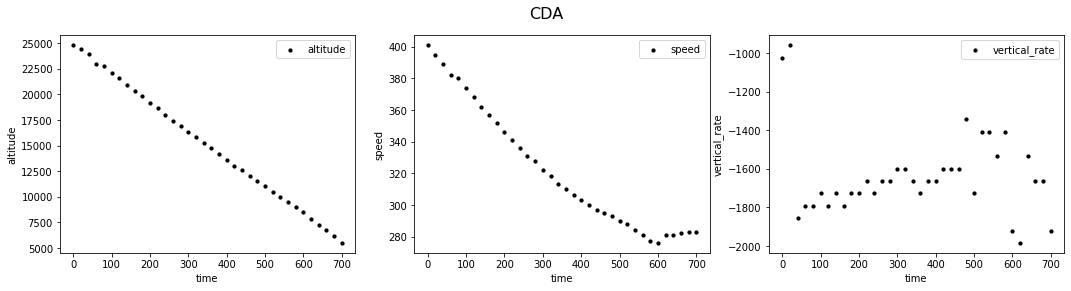

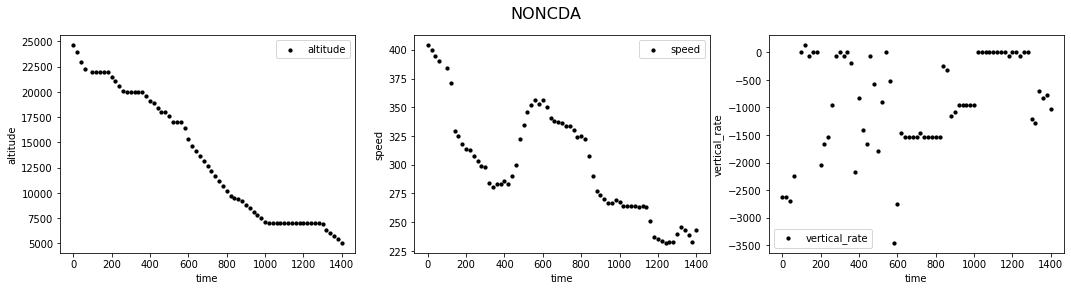

In [39]:
# Plot data and inspect the relationship  
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle('CDA', fontsize=16)
plot_data(ax[0], df_cda, 'time', 'altitude')
plot_data(ax[1], df_cda, 'time', 'speed')
plot_data(ax[2], df_cda, 'time', 'vertical_rate')
                       
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle('NONCDA', fontsize=16)
plot_data(ax[0], df_noncda, 'time', 'altitude')
plot_data(ax[1], df_noncda, 'time', 'speed')
plot_data(ax[2], df_noncda, 'time', 'vertical_rate')

In [40]:
# train & text split
df_cda_train = df_cda.sample(frac=0.6,random_state=0)
df_cda_test = df_cda.drop(df_cda_train.index)


df_noncda_train = df_noncda.sample(frac=0.6,random_state=0)
df_noncda_test = df_noncda.drop(df_noncda_train.index)

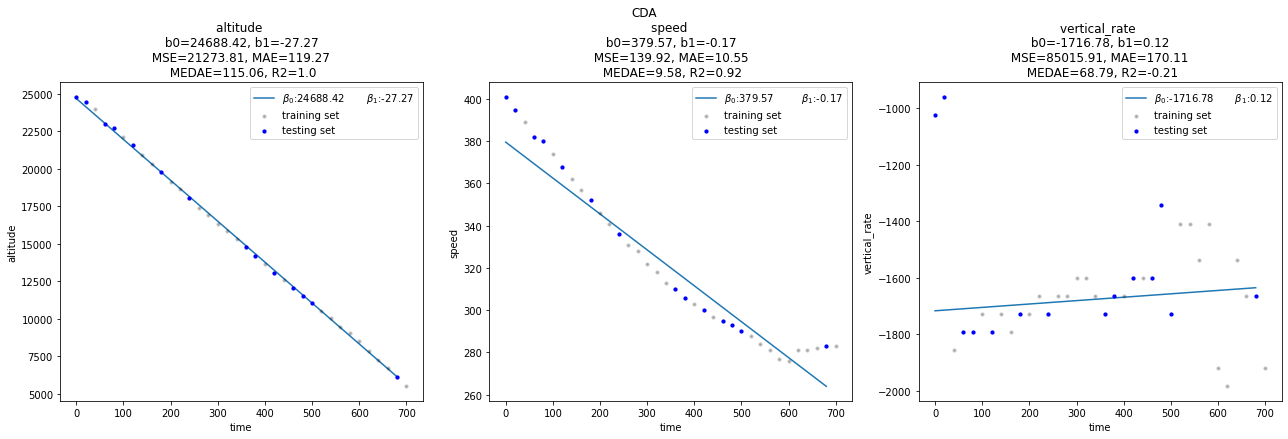

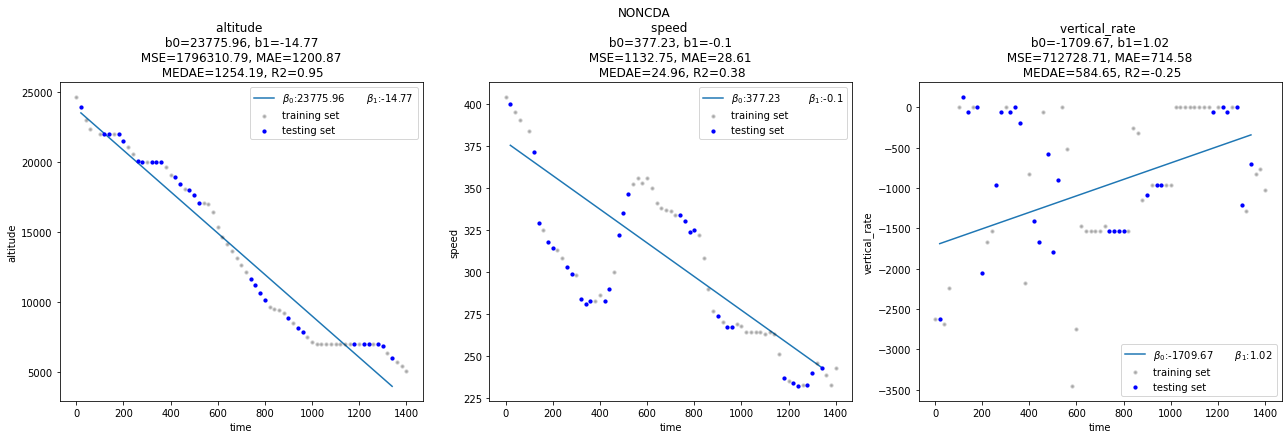

In [41]:
# Model training

# CDA 

x_param = 'time'
y_params = ['altitude', 'speed', 'vertical_rate']

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, y_param in enumerate(y_params):
    # assign train & test data
    x_train = df_cda_train[x_param].values
    y_train = df_cda_train[y_param].values
    x_test = df_cda_test[x_param].values
    y_test = df_cda_test[y_param].values
    
    # Use linear regression fro Sci-learn
    lr = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
    # Return the parameters
    b0 = lr.intercept_.round(2)
    b1 = lr.coef_[0].round(2)

    # evaluation
    MSE = mean_squared_error(y_test, lr.predict(x_test.reshape(-1, 1))).round(2)
    MAE = mean_absolute_error(y_test, lr.predict(x_test.reshape(-1, 1))).round(2)
    MEDAE = median_absolute_error(y_test, lr.predict(x_test.reshape(-1, 1))).round(2)
    R2 = r2_score(y_test, lr.predict(x_test.reshape(-1, 1))).round(2)
    
    # plot
    ax[i].scatter(x_train,y_train,color="k",s=5,lw=2,alpha=0.2, label="training set",zorder=10)
    ax[i].scatter(x_test,y_test,color="b",s=5,lw=2,label="testing set",zorder=10)
    plot_predict(ax[i], b0, b1, x_test, y_test,'b')
    ax[i].set_title('{} \n b0={}, b1={} \n MSE={}, MAE={} \n MEDAE={}, R2={}'.format(y_param, b0, b1, MSE, MAE, MEDAE, R2))              
    ax[i].set_xlabel(x_param)
    ax[i].set_ylabel(y_param)   
    ax[i].legend()

plt.tight_layout()
plt.suptitle('CDA',va='bottom')
plt.show()


#NON_CDA

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, y_param in enumerate(y_params):
    # assign train & test data
    x_train = df_noncda_train[x_param].values
    y_train = df_noncda_train[y_param].values
    x_test = df_noncda_test[x_param].values
    y_test = df_noncda_test[y_param].values
    
    # Use linear regression fro Sci-learn
    lr = LinearRegression().fit(x_train.reshape(-1, 1), y_train)
    # Return the parameters
    b0 = lr.intercept_.round(2)
    b1 = lr.coef_[0].round(2)

    # evaluation
    MSE = mean_squared_error(y_test, lr.predict(x_test.reshape(-1, 1))).round(2)
    MAE = mean_absolute_error(y_test, lr.predict(x_test.reshape(-1, 1))).round(2)
    MEDAE = median_absolute_error(y_test, lr.predict(x_test.reshape(-1, 1))).round(2)
    R2 = r2_score(y_test, lr.predict(x_test.reshape(-1, 1))).round(2)
    
    # plot
    ax[i].scatter(x_train,y_train,color="k",s=5,lw=2,alpha=0.2,label="training set",zorder=10)
    ax[i].scatter(x_test,y_test,color="b",s=5,lw=2,label="testing set",zorder=10)
    plot_predict(ax[i], b0, b1, x_test, y_test,'b')
    ax[i].set_title('{} \n b0={}, b1={} \n MSE={}, MAE={} \n MEDAE={}, R2={}'.format(y_param, b0, b1, MSE, MAE, MEDAE, R2))           
    ax[i].set_xlabel(x_param)
    ax[i].set_ylabel(y_param)   
    ax[i].legend()

plt.tight_layout()
plt.suptitle('NONCDA',va='bottom')
plt.show()

From the figures regarding time vs. (altitude, speed, vertical rate), we can see that:

(1) Time and altitude has a linear relationship as for CDA trajectories, but not in NONCDA trajectories.

(2) Time and speed has an almost linear relationship, except for the end of the time period. But for NONCDA trajectories, the relationship is not linear.

(3) Time and vertical rate is not linear related in both CDA and NON-CDA trajectories.

Based on what we obtain above, we can infer that linear regression can give a good prediction for CDA time-altitude, a less good prediction for CDA time-speed. In other cases, the performance of the linear regression model will be rather poor.

Then the linear regression is applied to CDA and NON-CDA data, and we use four types of metrics - MSE, MAE, MEDAE and R2 score, to evaluate the predicted results.

From the figures showing the model prediction vs. training and testing data, we can see that:

(1) Time and altitude: CDA gives the best result. R2 score is 1.0, indicating that the model can capture the change in the data really well. As for NON-CDA trajectories, R2 score is 0.95, indicating that the linear model can capture the featuress of the variation in the data. However, as we can see from the figure of test data poits and predicted linear model, it cannot give a well-fitted prediction. In the other hand, the MSE, MAE and MEDAE of NON-CDA  are much higher than that of CDA, indicating that the linear model may not be as well-performed as in case of CDA.

(2) Time and speed: we can see that in case of CDA, the linear regression model gives a good result. The R2 score is 0.92, indicating that the model can capture the variation in data quite well. As for NON-CDA trajectories, the R2 score is much lower than that of CDA, also the MSE, MAE and MEDAE are much larger.

(3) Time and vertical rate: the linear model is not suitable for both CDA and NON-CDA.

Also, as we can see the MSE, MAE and MEDAE cannot be compared for different cases, due to the different value range in different cases. For example, the MSE value in CDA (time,altitude) is much larger than CDA (time, speed) model, but apparently the linear regression model gives a better result in CDA (time,altitude) than in  CDA (time, speed) model.





# Task 2: Multiple linear regression

In this task you will learn how to apply Polynomial regression model. To complete the task, follow the steps below:

1. Using the same trajectories from the previous task, but choose both speed and altitude as predictors for the vertical rate. 

1. Construct a 3D multiple linear regression model

1. Visualize your result and briefly analyze your results.

In [42]:
# Task2
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
def plotdata3D(ax):
    ax.scatter(
        x_train[:, 0], x_train[:, 1], y_train, color="k", s=15, label="training data"
    )

    ax.scatter(
        x_test[:, 0], x_test[:, 1], y_test, color="r", s=25, label="testing data"
    )

    ax.set_xlabel("speed")
    ax.set_ylabel("vertical_rate")
    ax.set_zlabel("altitude")
    ax.legend()

CDA Results: 
 MAE: 1758.58  
 MEDAE: 1158.77
 RMSE: 2467.03 
 R2_score:0.88


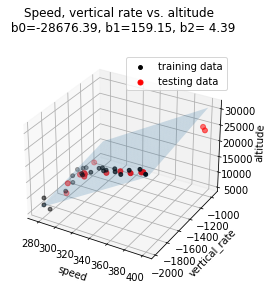

In [43]:
# CDA

# Assign training and testing data
x_train, y_train = df_cda_train[['speed', 'vertical_rate']].values, df_cda_train['altitude'].values
x_test, y_test = df_cda_test[['speed', 'vertical_rate']].values, df_cda_test['altitude'].values

# Multiple linera regression
model = LinearRegression().fit(x_train, y_train)
b0 = model.intercept_.round(2)
b1, b2 = model.coef_.round(2)

# Evaluation
y_predict = b0 + b1 * x_test[:, 0] + b2 * x_test[:, 1]

mae = mean_absolute_error(y_predict, y_test).round(2)
medae = median_absolute_error(y_predict, y_test).round(2)
rmse = np.sqrt(mean_squared_error(y_predict, y_test)).round(2)
r2 = r2_score(y_predict, y_test).round(2)

print('CDA Results: \n MAE: {}  \n MEDAE: {}\n RMSE: {} \n R2_score:{}'.format(mae,medae,rmse,r2))

# plot data
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plotdata3D(ax)

# plot prediction
x10, x11 = int(min(df_cda[['speed']].values)),int(max(df_cda[['speed']].values))
x20 , x21 = int(min(df_cda[['vertical_rate']].values)),int(max(df_cda[['vertical_rate']].values))
x1, x2 = np.meshgrid(range(x10,x11),range(x20,x21))
z = b0 + b1 * x1 + b2 * x2
ax.plot_surface(x1, x2, z, alpha=0.2)
ax.set_title('Speed, vertical rate vs. altitude \n b0={}, b1={}, b2= {}\n'.format(b0, b1, b2))

plt.tight_layout()

CDA Results: 
 MAE: 4096.94  
 MEDAE: 3738.26
 RMSE: 5163.92 
 R2_score:-0.42


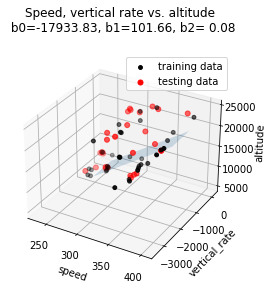

In [44]:
# NONCDA

# Assign training and testing data
x_train, y_train = df_noncda_train[['speed', 'vertical_rate']].values, df_noncda_train['altitude'].values
x_test, y_test = df_noncda_test[['speed', 'vertical_rate']].values, df_noncda_test['altitude'].values

# Multiple linera regression
model = LinearRegression().fit(x_train, y_train)
b0 = model.intercept_.round(2)
b1, b2 = model.coef_.round(2)

# Evaluation
y_predict = b0 + b1 * x_test[:, 0] + b2 * x_test[:, 1]

mae = mean_absolute_error(y_predict, y_test).round(2)
medae = median_absolute_error(y_predict, y_test).round(2)
rmse = np.sqrt(mean_squared_error(y_predict, y_test)).round(2)
r2 = r2_score(y_predict, y_test).round(2)

print('CDA Results: \n MAE: {}  \n MEDAE: {}\n RMSE: {} \n R2_score:{}'.format(mae,medae,rmse,r2))

# plot data
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plotdata3D(ax)

# plot prediction
x10, x11 = int(min(df_cda[['speed']].values)),int(max(df_cda[['speed']].values))
x20 , x21 = int(min(df_cda[['vertical_rate']].values)),int(max(df_cda[['vertical_rate']].values))
x1, x2 = np.meshgrid(range(x10,x11),range(x20,x21))
z = b0 + b1 * x1 + b2 * x2
ax.plot_surface(x1, x2, z, alpha=0.2)
ax.set_title('Speed, vertical rate vs. altitude \n b0={}, b1={}, b2= {}\n'.format(b0, b1, b2))
plt.tight_layout()

From the two figures above, we can see that in case of CDA, the speed and vertical_rate have an linear relationship with altitude. And in case of NON-CDA, the multiple linear regression model does not perform well. 

To evaluate the results, here we use four metrics which are mean absolute error (MAE), median absolute error (MedAE), root mean square error (RMSE), and R square score (R2). The same conclusion can be drawen from the metrics we obtain. The R2 score is 0.88 in case of CDA, indicating a good fitting, and the values of other three metrics (MAE, MEDAE and RMSE) are all smaller than that of NON-CDA. The R2 score is negative as for NON-CDA, indicating that the model performs even worse than applying a horizontal line (y = ave(y)).

# Task 3: Polynomial regression

In this task you will learn how to apply Polynomial regression model. To complete the task, follow the steps below:

1. Based on previous trajectories, apply polynomial regression, using altitude as input and speed as output. 

1. Try out different orders of polynomials.

1. Analyze your choice briefly. Taking into consideration of bias-variance trade-off.

1. Applying regularization to a high-order polynomial model you have tried earlier. Write a brief analysis of your result.


In [45]:
# write your code here

# create more cells if needed




(this is a markdown cell)

write your analysis here






# Task 4: Logistic regression

In this task you will learn how to apply Logistic regression model. You need to generate a new dataset based on given data. To complete the task, follow the steps below:

1. For all trajectories in CDA and NON-CDA group, apply linear regression, using time as input and altitude as output.

1. Calculate MAE for all regression models. Construct a dataset with MAE as input, and CDA status as output (CDA as 0, and NON-CDA as 1).

1. Determine the Logistic regression model describe the relationship between MAE and CDA status

In [46]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [47]:
def expit(x):
    return 1 / (1 + np.exp(-x))

In [78]:
def calcMAE(df):
    # complete this function for calculating MAE
    # [TODO] fit linear model to time and altitude
    time = df.time
    altitude = df.altitude
    
    # split in train and test data 
    time_train, time_test, altitude_train, altitude_test = train_test_split(time, altitude, test_size=0.3, random_state=4)

    # apply linear regression model on the test data 
    lr = LinearRegression().fit(time_train.values.reshape(-1, 1), altitude_train)
    
    # calculate MAE (Mean Absolute Error) by comparing LR-model with the test data. 
    MAE = mean_absolute_error(altitude_test, lr.predict(time_test.values.reshape(-1,1)))
    
    return MAE


new_data = []

for f in cda_files:
    df = pd.read_csv(f)
    MAE = calcMAE(df)
    new_data.append((MAE, 0))

for f in noncda_files:
    df = pd.read_csv(f)
    MAE = calcMAE(df)
    new_data.append((MAE, 1))

Text(0.5, 1.0, 'Linear Regression model')

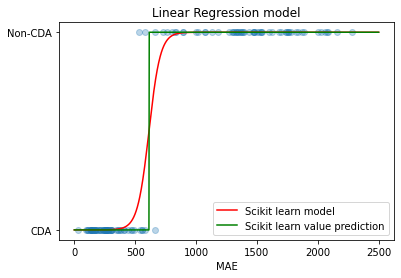

In [79]:
# for loops are now so that left column = MAE, right column is 0 or 1 (cda or noncda)
new_data = np.array(new_data)

MAE = new_data[:,0].reshape(-1,1)
CDA_index = new_data[:,1].reshape(-1,1)


X_test = np.linspace(0,2500,1000)


logreg = LogisticRegression().fit(MAE, CDA_index)
CDA_predict = expit(X_test * logreg.coef_ + logreg.intercept_).squeeze()
CDA_predict2 = logreg.predict(X_test.reshape(-1, 1))

# visualize new data set 
plt.figure()
plt.scatter(MAE, CDA_index, alpha=0.3)
plt.plot(X_test, CDA_predict, color='r', label='Scikit learn model')
plt.plot(X_test, CDA_predict2, color='g', label='Scikit learn value prediction')
plt.xlabel('MAE')
plt.yticks(ticks=[1,0], labels=['Non-CDA', 'CDA'])
plt.legend()
plt.title('Linear Regression model')

The following steps were taken in order to acquire the right results. 
First a linear regression model (for time vs altitude) was made for all trajectories in the CDA and Non-CDA group. To do this, for each data set the data was split into a training and testing set (training 70%, testing 30%). The model was made using the training set, and after that the predictions based on the model were compared with the data from the testing set. These results were used to calculate the Mean Absolute Error (MAE) for each trajectory. 

This MAE was combined with the CDA / Non-CDA index. (CDA = 0, non-CDA = 1). A logistic regression model was computed using `sklearn.linear_model.LogisticRegression` using all the MAE and CDA_index data to train the model. 
To visualize this model a 'X_test' string containing 1000 values along the x-axis was computed and the coefficients from the logistic regression were used to plot the red model in the graph above. 

From the computed logistic regression model we can state that the CDA trajectories have a lower MAE in general. So if the MAE is low, the trajectory is most probable CDA, with a turning point around MAE = 640. Meaning that for MAE < 640, the trajectory is more likely to be CDA and for MAE > 640 the trajectory is more likely to be non-CDA. 

# Task 5: Bayesian regression

In this task you will learn how to apply Bayesian regression model. I recommend to use of `pymc3` library. To complete the task, follow the steps below:

1. Apply Bayesian linear regression to vertical speed of CDA and Non-CDA trajectories (time as input). Provide an analysis of your result.

1. **(Bonus)** Design a quadratic model to altitude using the Bayesian regression approach. Visualize and analyze your findings.



In [80]:
# write your code here

# create more cells if needed

# Tip: try different prior probability density functions of parameters. If the regression fails:
#   1. change the initial guess.
#   2. change the variance for the priors of the random variables


In [81]:
# Perform data preprocessing
#   - Combine data from all cda into single array (same for non cda)
#   - Split data into test and train set
from sklearn.model_selection import train_test_split

X_var = 'time'
y_var = 'vertical_rate'
train_size = 0.8    

all_data = {'cda':      cda_files, 
            'non cda':  noncda_files}
X_train, X_test, y_train, y_test = {}, {}, {}, {}

for item in all_data.keys():    # iterate over 1. cda, 2. non cda
    X, y = [], []
    for f in all_data[item]:
        df = pd.read_csv(f)
        X.append(df.loc[:, X_var].to_numpy())
        y.append(df.loc[:, y_var].to_numpy())

    X = np.array([item for sublist in X for item in sublist])   # create a 1-dimensional array
    y = np.array([item for sublist in y for item in sublist])   # create a 1-dimensional array

    X_train[item], X_test[item], y_train[item], y_test[item] = train_test_split(X, y, train_size=train_size, random_state=1)


In [82]:
# perform bayesian linear regression 
import pymc3 as pm

trace_dict = {}     # used to store the trace output for 1. cda, 2. non cda

for item in all_data.keys():
    print(f'Starting the {item} data points analysis ...')
    with pm.Model() as model:
        beta_0 = pm.Normal("beta_0", mu=-1500, sd=1000)     # initial guesses
        beta_1 = pm.Normal("beta_1", mu=0, sd=200)          # initial guesses
        sigma  = pm.HalfNormal("sigma", sd=1000)            # initial guesses

        y = pm.Normal("y", mu=beta_0 + beta_1 * X_train[item], sd=sigma, observed=y_train[item])

        # using the simplest MH sampler
        step = pm.Metropolis()

        # we are drawing 5000 samples using 4 chains
        trace = pm.sample(draws=5000, step=step, chains=4)
        trace_dict[item] = trace

ModuleNotFoundError: No module named 'pymc3'

           mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta_0 -1633.61  14.37 -1661.08 -1606.79       0.69     0.49    438.30   
beta_1     0.61   0.03     0.56     0.65       0.00     0.00    377.83   
sigma    366.96   5.71   355.97   377.05       0.12     0.08   2303.95   

         ess_sd  ess_bulk  ess_tail  r_hat  
beta_0   438.30    438.88   1122.06   1.01  
beta_1   377.83    378.05    693.48   1.01  
sigma   2303.95   2303.40   2218.59   1.00  


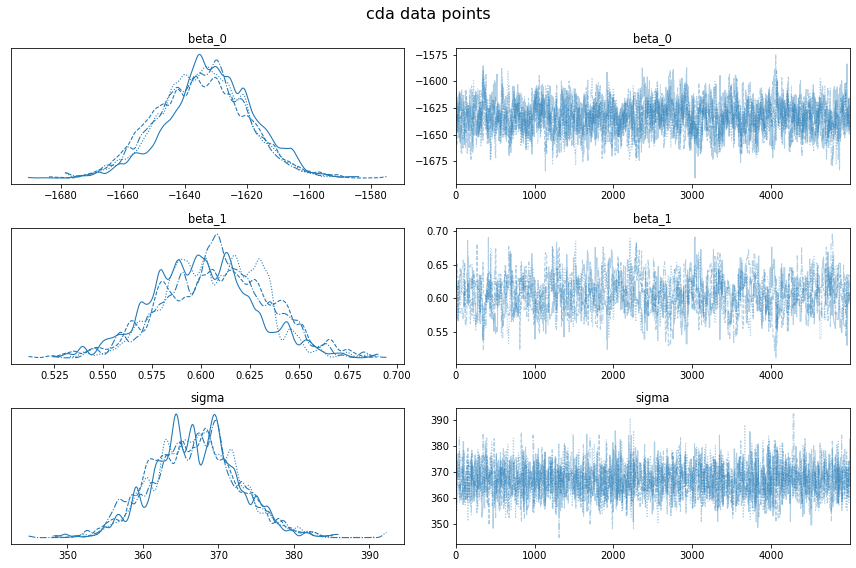

           mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
beta_0 -1481.72  26.40 -1531.31 -1431.79       1.07     0.76    609.25   
beta_1     0.73   0.04     0.66     0.79       0.00     0.00    555.76   
sigma    777.43  10.20   757.91   796.14       0.24     0.17   1840.63   

         ess_sd  ess_bulk  ess_tail  r_hat  
beta_0   609.10    609.42   1489.14   1.00  
beta_1   555.73    555.30   1105.99   1.01  
sigma   1840.63   1830.68   1713.28   1.00  


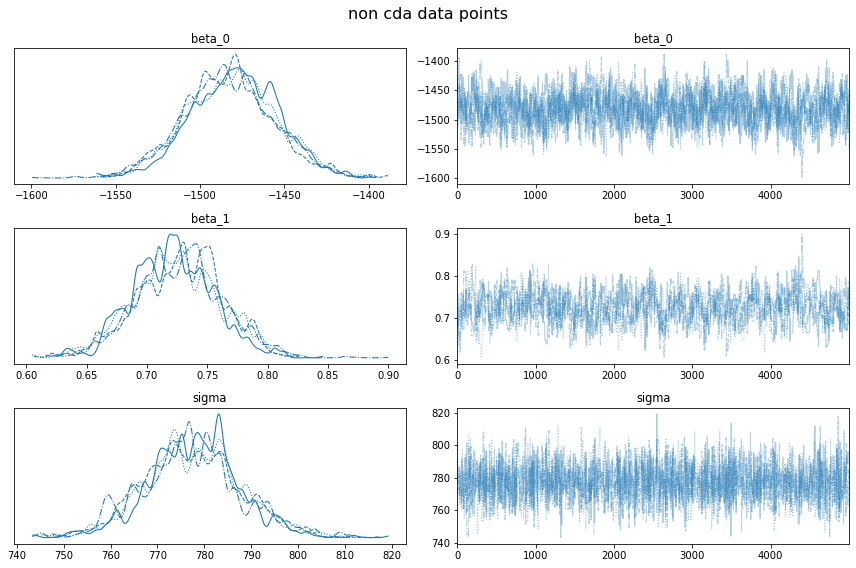

In [ ]:
# Show the results of the final parameters
import arviz as az

for item in all_data.keys():
    print(az.summary(trace_dict[item], round_to=2))
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    fig.suptitle(f'{item} data points', fontsize=16)
    pm.traceplot(trace_dict[item], axes=axes)
    plt.tight_layout()
    plt.show()

In [ ]:
# Perform reference linear regression for comparison
from sklearn.linear_model import LinearRegression

linreg_dict = {}

for item in all_data.keys():
    linreg = LinearRegression()
    linreg.fit(X_train[item].reshape(-1, 1), y_train[item])
    linreg_dict[item] = linreg

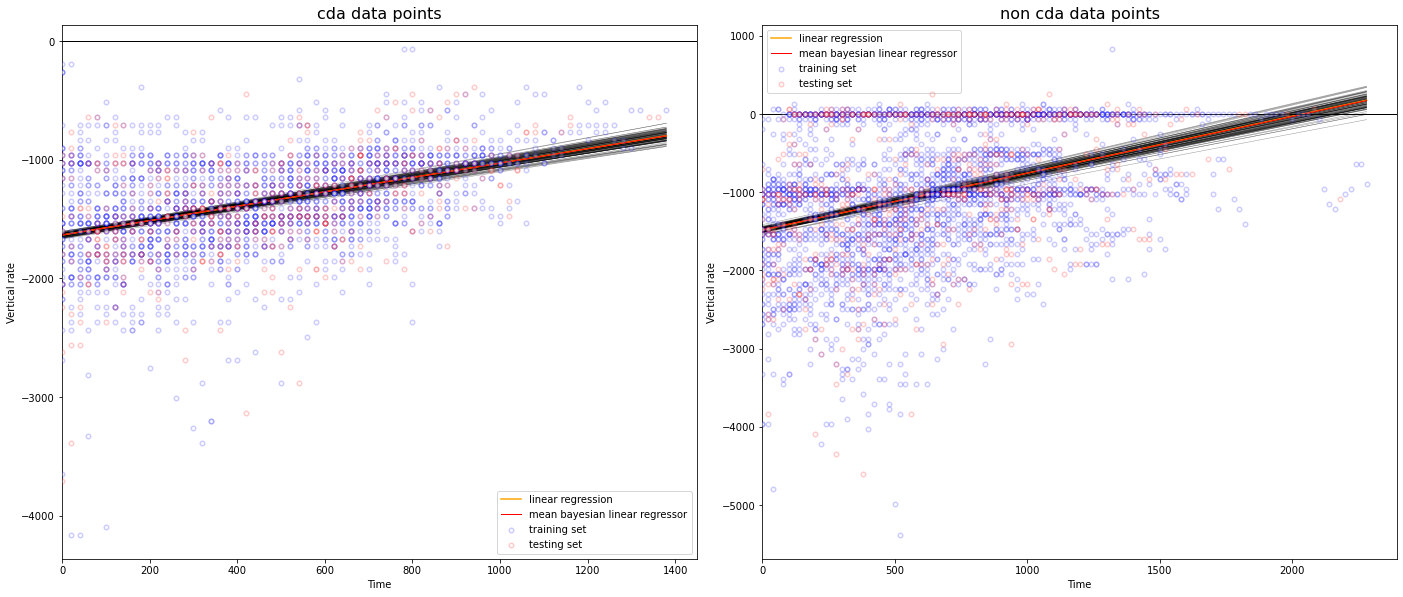

In [ ]:
# plot the final results

fig_scale = 1.4
fig, axes = plt.subplots(1, 2, figsize=(14*fig_scale, 6*fig_scale))

data_labels = list(all_data.keys())
blr_coef = {}

for i in range(len(data_labels)):
    item = data_labels[i]

    axes[i].set_title(f'{item} data points', fontsize=16)
    axes[i].scatter(X_train[item], y_train[item], s=20, lw=1.5, color='b', label="training set", facecolor="w", zorder=10, alpha=0.2)
    axes[i].scatter(X_test[item], y_test[item],  s=20, lw=1.5, color="r", label="testing set", facecolor="w", zorder=10, alpha=0.2)

    x_ = np.linspace(X_train[item].min(), X_train[item].max(), 100)
    for j in range(100):
        b0 = np.random.choice(trace_dict[item]["beta_0"])
        b1 = np.random.choice(trace_dict[item]["beta_1"])
        axes[i].plot(x_, b0 + b1 * x_, lw=0.5, color="k", alpha=0.4)   
    
    axes[i].plot(x_, linreg_dict[item].predict(x_.reshape(-1,1)), 'orange', label='linear regression')    # 'normal' linear regression

    b0_mean = trace_dict[item]["beta_0"].mean()
    b1_mean = trace_dict[item]["beta_1"].mean()
    sigma_mean = trace_dict[item]["sigma"].mean()
    blr_coef[item] = [b0_mean, b1_mean, sigma_mean]

    axes[i].plot(x_, b0_mean + b1_mean * x_, lw=1, color="r", label="mean bayesian linear regressor")   # mean of the bayesian linear regression
    axes[i].set_xlabel(X_var.capitalize())
    axes[i].axhline(0, color='k', linewidth=1, linestyle='-')
    axes[i].set_ylabel(y_var.replace('_', ' ').capitalize())
    axes[i].legend()
    axes[i].set_xlim(0, None)

plt.tight_layout()
plt.show()

In [ ]:
# Compare error metrics
from sklearn.metrics import mean_squared_error

for item in all_data.keys():
    MSE_lr = mean_squared_error(y_test[item], linreg_dict[item].predict(X_test[item].reshape(-1, 1)))
    print(f'Linear Regression testing results {item}:\n\tMSE: {MSE_lr.round(2)}\n\tRMSE:{np.sqrt(MSE_lr).round(2)}')

    MSE_blr = mean_squared_error(y_test[item], blr_coef[item][0] + blr_coef[item][1] * X_test[item])
    print(f'Average Bayesian Linear Regression testing results {item}:\n\tMSE: {MSE_blr.round(2)}\n\tRMSE:{np.sqrt(MSE_blr).round(2)}')

Linear Regression testing results cda:
	MSE: 137767.75
	RMSE:371.17
Average Bayesian Linear Regression testing results cda:
	MSE: 137776.57
	RMSE:371.18
Linear Regression testing results non cda:
	MSE: 608557.34
	RMSE:780.1
Average Bayesian Linear Regression testing results non cda:
	MSE: 608559.74
	RMSE:780.1


Analysis of above methods and results:

-   To start this task, the input and output data was retrieved for all CDA and NON CDA data files, and split into a trainging and test set (80% - 20%) to allow to compute error metrics afterwards.
-   To perform the bayesian linear regression, three random variables are to be defined: beta_0, beta_1, and sigma; which are taken to follow a Normal, Normal, and Half Normal distribution, respectively. The initial guesses for the mean and stdv are found by trial and error such that the final model converges to an optimal solution. These probability metrics were found to give the required results.
-   For the optimisation method, the simplest Metropolis (MH) sampler is used, as this is found to get the job done. Furthermore, four chains are used to ensure a converged solution.
-   Subsequently, the random variables as obtained from the optimisation are plotted, from which it becomes clear that each of the four chains converged to a similar probability distribution.
-   By using the optimised random variables for the bayesian linear regression prediction, the final results are plotted together with the train and test data points. Here, both the mean of the bayesian linear regression, as well as the uncertainty range becomes visible. To check whether the obtained mean bayesian liner regression corresponds to a 'normal' linear regression analysis, the latter line is also added to the graph. It can be seen that both lines coincide, which indicates that the found bayesian linear regression solution actually is correct.
-   Finally, both the MSE and RMSE are computed for the test data, for both the 'normal' linear regressor, and the mean of the bayesian linear regressor. These values are seen to be similar, which again indicates a correct implimentation of the model.

====================================================================

2. **(Bonus)** Design a quadratic model to altitude using the Bayesian regression approach. Visualize and analyze your findings.

In [ ]:
from sklearn.model_selection import train_test_split

# Perform data preprocessing
#   - Combine data from all cda into single array (same for non cda)
#   - Split data into test and train

X_var = 'time'
y_var = 'altitude'
train_size = 0.8    

all_data = {'cda':      cda_files, 
            'non cda':  noncda_files}
X_train, X_test, y_train, y_test = {}, {}, {}, {}

for item in all_data.keys():    # iterate over 1. cda, 2. non cda
    X, y = [], []
    for f in all_data[item]:
        df = pd.read_csv(f)
        X.append(df.loc[:, X_var].to_numpy())
        y.append(df.loc[:, y_var].to_numpy())

    X = np.array([item for sublist in X for item in sublist])   # create a 1-dimensional array
    y = np.array([item for sublist in y for item in sublist])   # create a 1-dimensional array

    X_train[item], X_test[item], y_train[item], y_test[item] = train_test_split(X, y, train_size=train_size, random_state=1)


In [ ]:
import pymc3 as pm

trace_dict = {}     # used to store the trace output for 1. cda, 2. non cda

# perform bayesian quadratic regression 
for item in all_data.keys():
    print(f'Starting the {item} data points analysis ...')
    with pm.Model() as model:

        beta_0 = pm.Normal("beta_0", mu=25_000, sd=1000)   # initial guesses
        beta_1 = pm.Normal("beta_1", mu=0, sd=20)       # initial guesses
        beta_2 = pm.Normal("beta_2", mu=0, sd=20)       # initial guesses
        sigma  = pm.HalfNormal("sigma", sd=1000)         # initial guesses

        y = pm.Normal("y", mu=beta_0 + beta_1 * X_train[item] + beta_2 * X_train[item]**2, sd=sigma, observed=y_train[item])

        # using the simplest MH sampler
        # step = pm.Metropolis()
        step = pm.NUTS()

        # we are drawing 8000 samples using 4 chains
        trace = pm.sample(draws=8000, step=step, chains=4)
        trace_dict[item] = trace

Starting the cda data points analysis ...


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, beta_2, beta_1, beta_0]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 168 seconds.


Starting the non cda data points analysis ...


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, beta_2, beta_1, beta_0]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 129 seconds.


             mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
beta_0  25642.486  100.878  25451.744  25831.284      0.940    0.665   
beta_1    -32.528    0.437    -33.344    -31.695      0.004    0.003   
beta_2      0.013    0.000      0.012      0.014      0.000    0.000   
sigma    1789.523   27.673   1738.465   1841.892      0.212    0.150   

         ess_mean     ess_sd   ess_bulk   ess_tail  r_hat  
beta_0  11506.838  11506.838  11507.871  15458.932  1.001  
beta_1   9980.266   9980.266   9984.692  13488.049  1.001  
beta_2  10653.072  10653.072  10653.302  14488.798  1.001  
sigma   17055.985  17055.985  17048.723  17015.310  1.000  


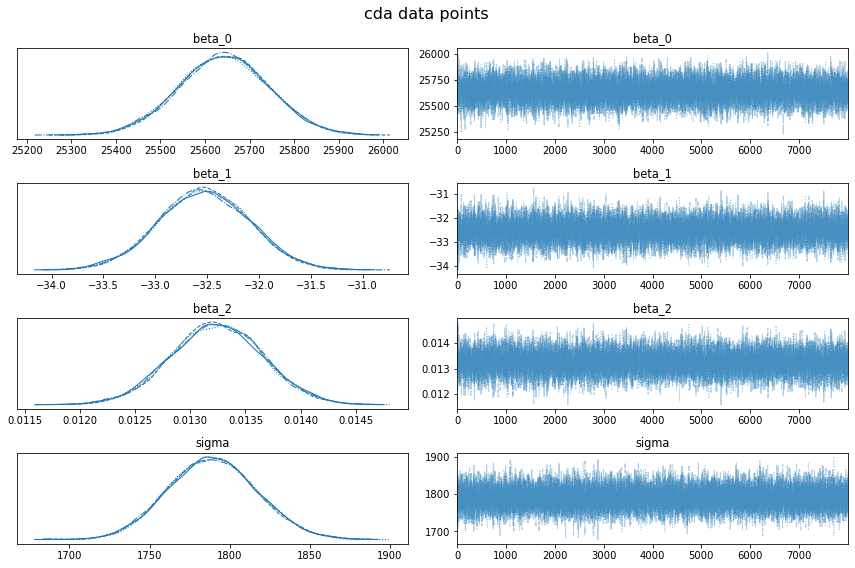

             mean       sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
beta_0  25048.417  136.360  24788.974  25300.447      1.250    0.884   
beta_1    -25.923    0.388    -26.638    -25.187      0.004    0.003   
beta_2      0.009    0.000      0.008      0.009      0.000    0.000   
sigma    2900.563   38.425   2827.072   2971.696      0.285    0.202   

         ess_mean     ess_sd   ess_bulk   ess_tail  r_hat  
beta_0  11900.814  11898.928  11905.274  14990.143  1.000  
beta_1  10507.846  10501.383  10506.513  12976.651  1.001  
beta_2  11447.884  11440.866  11442.003  14653.907  1.001  
sigma   18162.277  18157.716  18158.145  17281.999  1.000  


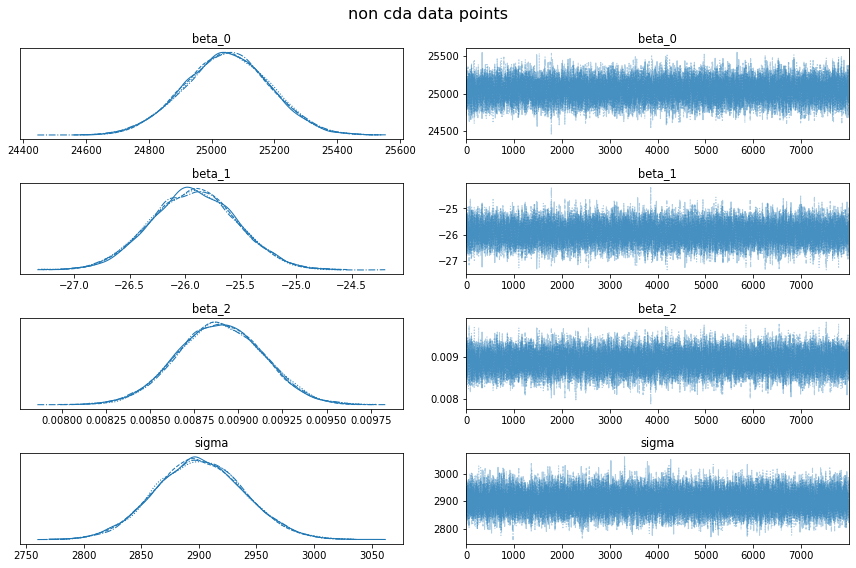

In [ ]:
# Show the results of the final parameters
import arviz as az

for item in all_data.keys():
    print(az.summary(trace_dict[item], round_to=3))

    fig, axes = plt.subplots(4, 2, figsize=(12, 8))
    fig.suptitle(f'{item} data points', fontsize=16)
    pm.traceplot(trace_dict[item], axes=axes)
    plt.tight_layout()
    plt.show()

In [ ]:
# Perform reference quadratic regression for comparison
qr_coef = {}

for item in all_data.keys():
    k = 2
    coef_np = np.polyfit(X_train[item], y_train[item], deg=k)
    coef = coef_np[::-1]
    qr_coef[item] = coef

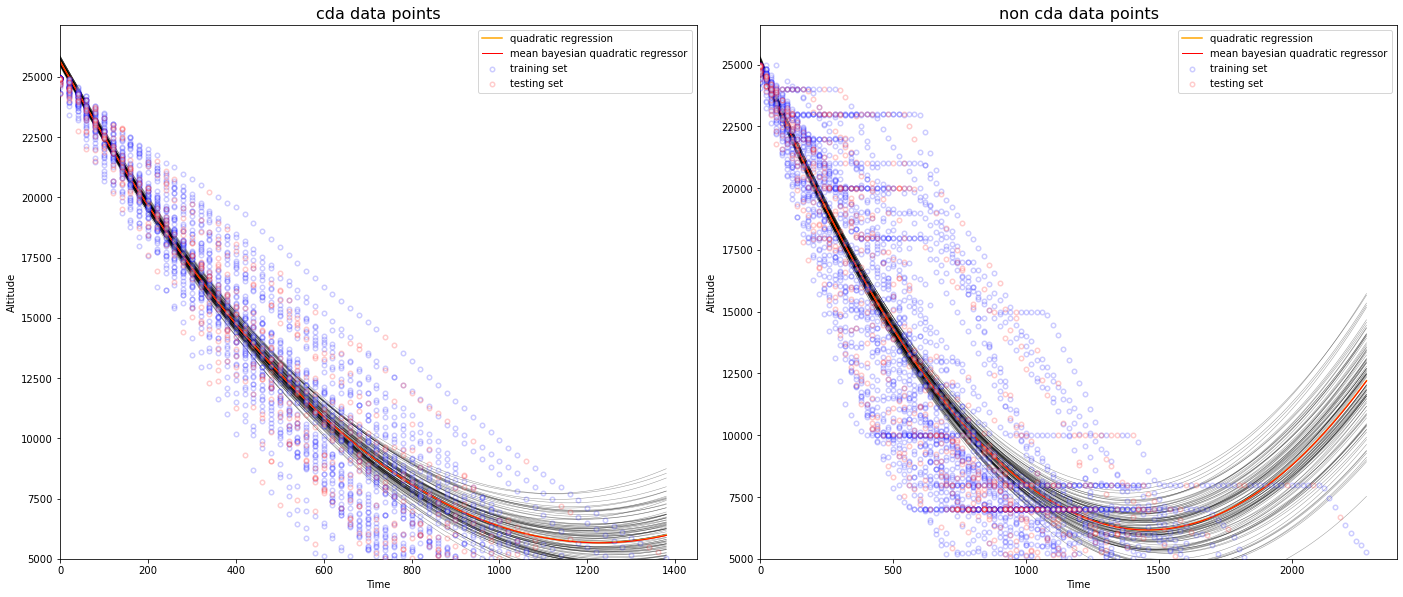

In [ ]:
# plot the results

fig_scale = 1.4
fig, axes = plt.subplots(1, 2, figsize=(14*fig_scale, 6*fig_scale))

data_labels = list(all_data.keys())
bqr_coef = {}   # bayesian quadratic coefficients 

for i in range(len(data_labels)):
    item = data_labels[i]
    
    axes[i].set_title(f'{item} data points', fontsize=16)
    axes[i].scatter(X_train[item], y_train[item], s=20, lw=1.5, color='b', label="training set", facecolor="w", zorder=10, alpha=0.2)
    axes[i].scatter(X_test[item], y_test[item],  s=20, lw=1.5, color="r", label="testing set", facecolor="w", zorder=10, alpha=0.2)

    x_ = np.linspace(X_train[item].min(), X_train[item].max(), 100)
    for j in range(100):
        b0 = np.random.choice(trace_dict[item]["beta_0"])
        b1 = np.random.choice(trace_dict[item]["beta_1"])
        b2 = np.random.choice(trace_dict[item]["beta_2"])
        axes[i].plot(x_, b0 + b1 * x_ + b2 * x_**2, lw=0.5, color="k", alpha=0.4)

    axes[i].plot(x_, qr_coef[item][0] + qr_coef[item][1]*x_ + qr_coef[item][2]*x_**2, 'orange', label='quadratic regression')     # 'normal' quadratic regression
    
    b0_mean = trace_dict[item]["beta_0"].mean()
    b1_mean = trace_dict[item]["beta_1"].mean()
    b2_mean = trace_dict[item]["beta_2"].mean()
    sigma_mean = trace_dict[item]["sigma"].mean()
    bqr_coef[item] = [b0_mean, b1_mean, b2_mean, sigma_mean]

    axes[i].plot(x_, b0_mean + b1_mean * x_ + b2_mean * x_**2, lw=1, color="r", label="mean bayesian quadratic regressor")   # average bayesian quadratic regression

    axes[i].set_xlabel(X_var.capitalize())
    axes[i].axhline(0, color='k', linewidth=1, linestyle='-')
    axes[i].set_ylabel(y_var.replace('_', ' ').capitalize())
    axes[i].legend()
    axes[i].set_ylim(5000, None)
    axes[i].set_xlim(0, None)

plt.tight_layout()
plt.show()

In [ ]:
# Compare error metrics
from sklearn.metrics import mean_squared_error

for item in all_data.keys():
    MSE_qr = mean_squared_error(y_test[item], qr_coef[item][0] + qr_coef[item][1]*X_test[item] + qr_coef[item][2]*X_test[item]**2)
    print(f'Quadratic Regression testing results {item}:\n\tMSE: {MSE_qr.round(2)}\n\tRMSE:{np.sqrt(MSE_qr).round(2)}')

    MSE_bqr = mean_squared_error(y_test[item], bqr_coef[item][0] + bqr_coef[item][1] * X_test[item] + bqr_coef[item][2] * X_test[item]**2)
    print(f'Average Bayesian Quadratic Regression testing results {item}:\n\tMSE: {MSE_bqr.round(2)}\n\tRMSE:{np.sqrt(MSE_bqr).round(2)}')

Quadratic Regression testing results cda:
	MSE: 3226109.66
	RMSE:1796.14
Average Bayesian Quadratic Regression testing results cda:
	MSE: 3226120.53
	RMSE:1796.14
Quadratic Regression testing results non cda:
	MSE: 7719404.32
	RMSE:2778.38
Average Bayesian Quadratic Regression testing results non cda:
	MSE: 7719906.74
	RMSE:2778.47


Analysis of above methods and results:

-   Similar to part 1 of this task, first, the input and output data was retrieved for all CDA and NON CDA data files, and split into a training and test set (80% - 20%) to allow to compute error metrics afterwards.
-   To perform the bayesian quadratic regression, an additional random variable is needed in order to describe the relation. This results in a total of four random variables to be optimised. The initial guesses for these parameters turned out to be more sensitive compared to the bayesian linear regressor. More trial and error iterations were required to find initial values that resulted in a converged solution.
-   For the optimisation method, it was found that the simples Metropolis (MH) sampler was not able to converge to the optimal solution (while it did get close). Therefore, it was chosen to use the NUTS sampler, which resulted in a more accurate final solution. The number of draws was also increased from 4000 to 8000 to allow the optimiser more trials to reach convergence.
-   Subsequently, the random variables as obtained from the optimisation are plotted, from which it becomes clear that each of the four chains converged to a similar probability distribution.
-   By using the optimised random variables for the bayesian quadratic regression prediction, the final results are plotted together with the train and test data points. Here, both the mean of the bayesian quadratic regressor, as well as the uncertainty range becomes visible. To check whether the obtained mean bayesian quadratic regression corresponds to a 'normal' quadratic regression analysis, the latter line is also added to the graph. It can be seen that both lines coincide, which indicates that the found bayesian quadratic regression solution actually is correct.
-   Finally, both the MSE and RMSE are computed for the test data, for both the 'normal' quadratic regressor, and the mean of the bayesian quadratic regressor. These values are seen to be similar, which again indicates a correct implimentation of the model.